# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [1]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

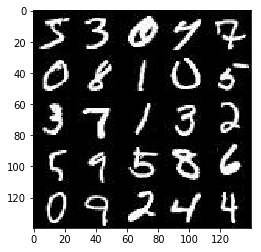

In [33]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(np.array(helper.images_square_grid(mnist_images, 'L')), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

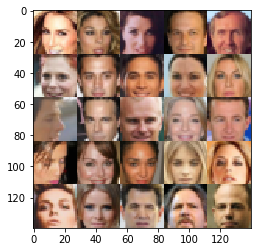

In [4]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [5]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.1.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [6]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    input_images = tf.placeholder(tf.float32, (None, image_width, image_height, image_channels), name='input_images') 
    z_data = tf.placeholder(tf.float32, (None, z_dim), name='z_data') 
    learning_rate = tf.placeholder(tf.float32, name='learning_rate') 
    return input_images, z_data, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [121]:
def discriminator(images, reuse=False):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function

    alpha=0.2
    x = images
    with tf.variable_scope('discriminator', reuse=reuse):
        # convolutional layer
        cov1 = tf.layers.conv2d(x, 512, 5, strides=2, padding="same")
        cov1 = tf.layers.batch_normalization(cov1, training=True)
        cov1 = tf.maximum(alpha * cov1, cov1)
        cov1 = tf.layers.dropout(cov1, 0.3)
        
        # convolutional layer
        cov2 = tf.layers.conv2d(cov1, 256, 4, strides=1, padding="same")
        cov2 = tf.layers.batch_normalization(cov2, training=True)
        cov2 = tf.maximum(alpha * cov2, cov2)
        cov2 = tf.layers.dropout(cov2, 0.7)

        # convolutional layer
        cov3 = tf.layers.conv2d(cov2, 128, 3, strides=1, padding="same")
        cov3 = tf.layers.batch_normalization(cov3, training=True)
        cov3 = tf.maximum(alpha * cov3, cov3)
        cov3 = tf.layers.dropout(cov3, 0.3)
    
        # fully connected layer
        fully = tf.reshape(cov2, (-1, 4*4*256))
        logits = tf.layers.dense(fully, 1)
        out = tf.sigmoid(logits)

    return out, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [111]:
def generator(z, out_channel_dim, is_train=True):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    
    alpha = 0.2    
    with tf.variable_scope('generator', reuse=not is_train):
        # Fully connected
        fully = tf.layers.dense(z, 7*7*512)
        fully = tf.reshape(fully, (-1, 7, 7, 512))
        fully = tf.maximum(alpha*fully, fully)
        
        # Starting Conv Transpose Stack
        conv1 = tf.layers.conv2d_transpose(fully, 256, 3, 1, 'SAME')
        conv1 = tf.layers.batch_normalization(conv1, training=is_train)
        conv1 = tf.maximum(alpha * conv1, conv1)
        
        conv2 = tf.layers.conv2d_transpose(conv2, 128, 3, 1, 'SAME')
        conv2 = tf.layers.batch_normalization(conv2, training=is_train)
        conv2 = tf.maximum(alpha * conv2, conv2)
        
        conv3 = tf.layers.conv2d_transpose(conv2, 64, 3, 2, 'SAME')
        conv3 = tf.layers.batch_normalization(conv3, training=is_train)
        conv3 = tf.maximum(alpha * conv3, conv3)
        
        # Logits
        logits = tf.layers.conv2d_transpose(conv3, out_channel_dim, 3, 2, 'SAME')
        
        # Output
        out = tf.tanh(logits)
        
        return out


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [112]:
def model_loss(input_real, input_z, out_channel_dim):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    
    gen_model = generator(input_z,out_channel_dim)
    d_model_real,d_logits_real =discriminator(input_real)
    d_model_fake,d_logits_fake =discriminator(gen_model,reuse=True)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real)*0.9))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake)))

    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss



"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [123]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    train_vars = tf.trainable_variables()
    gen_vars = [x for x in train_vars if x.name.startswith('generator')]
    disc_vars = [x for x in train_vars if x.name.startswith('discriminator')]
    with tf.control_dependencies(tf.get_collection(tf.GraphKeys.UPDATE_OPS)):
        discriminator_train_opt  = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(d_loss, var_list=disc_vars)
        generator_train_opt  = tf.train.AdamOptimizer(learning_rate=learning_rate, beta1=beta1).minimize(g_loss, var_list=gen_vars)
    
    return discriminator_train_opt , generator_train_opt 
    


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [114]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [115]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    total_data_size, image_width, image_height, image_channels = data_shape

    input_real, input_z, learning_rate_input = model_inputs(image_width, image_height, image_channels, z_dim)
    d_loss, g_loss = model_loss(input_real, input_z, image_channels)
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)

    steps = 0
    print_every = 10
    show_every = 100
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                batch_images *= 2
                steps += 1

                # Generate random noise
                batch_z = np.random.uniform(-1, 1, size=(batch_size, z_dim))

                # Run optimizers
                _ = sess.run(d_opt, feed_dict={input_real: batch_images, input_z: batch_z, 
                                               learning_rate_input: learning_rate})
                _ = sess.run(g_opt, feed_dict={input_z: batch_z, input_real: batch_images,
                                               learning_rate_input: learning_rate})

                if steps % print_every == 0:
                    # At the end of each epoch, get the losses and print them out
                    train_loss_d = d_loss.eval({input_z: batch_z, input_real: batch_images})
                    train_loss_g = g_loss.eval({input_z: batch_z})

                    print("Epoch {}/{} Batch Step {}...".format(epoch_i, epoch_count, steps),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g))
                    
                if steps % show_every == 0:
                    show_generator_output(sess, 20, input_z, image_channels, data_image_mode)
                
        print('Done Training!')
        show_generator_output(sess, 20, input_z, image_channels, data_image_mode)

                

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

Epoch 0/2 Batch Step 10... Discriminator Loss: 1.5212... Generator Loss: 0.6452
Epoch 0/2 Batch Step 20... Discriminator Loss: 1.3877... Generator Loss: 0.7403
Epoch 0/2 Batch Step 30... Discriminator Loss: 1.3235... Generator Loss: 0.7728
Epoch 0/2 Batch Step 40... Discriminator Loss: 1.2541... Generator Loss: 0.8300
Epoch 0/2 Batch Step 50... Discriminator Loss: 1.1549... Generator Loss: 0.8882
Epoch 0/2 Batch Step 60... Discriminator Loss: 1.1622... Generator Loss: 0.9120
Epoch 0/2 Batch Step 70... Discriminator Loss: 1.1375... Generator Loss: 0.9012
Epoch 0/2 Batch Step 80... Discriminator Loss: 1.0961... Generator Loss: 0.9547
Epoch 0/2 Batch Step 90... Discriminator Loss: 1.1684... Generator Loss: 0.8974
Epoch 0/2 Batch Step 100... Discriminator Loss: 1.2165... Generator Loss: 0.8889


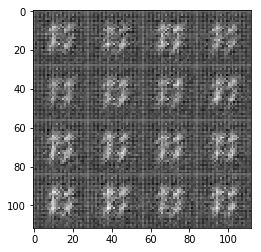

Epoch 0/2 Batch Step 110... Discriminator Loss: 1.2222... Generator Loss: 0.8846
Epoch 0/2 Batch Step 120... Discriminator Loss: 1.2264... Generator Loss: 0.8625
Epoch 0/2 Batch Step 130... Discriminator Loss: 1.2119... Generator Loss: 0.9164
Epoch 0/2 Batch Step 140... Discriminator Loss: 1.1726... Generator Loss: 0.9419
Epoch 0/2 Batch Step 150... Discriminator Loss: 1.1396... Generator Loss: 0.9641
Epoch 0/2 Batch Step 160... Discriminator Loss: 1.1578... Generator Loss: 0.9251
Epoch 0/2 Batch Step 170... Discriminator Loss: 1.1115... Generator Loss: 1.0039
Epoch 0/2 Batch Step 180... Discriminator Loss: 1.1457... Generator Loss: 0.9640
Epoch 0/2 Batch Step 190... Discriminator Loss: 1.0695... Generator Loss: 1.0358
Epoch 0/2 Batch Step 200... Discriminator Loss: 1.0375... Generator Loss: 1.0684


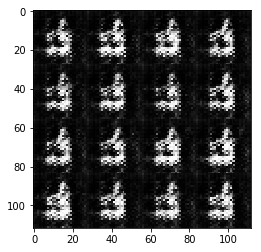

Epoch 0/2 Batch Step 210... Discriminator Loss: 1.0124... Generator Loss: 1.0845
Epoch 0/2 Batch Step 220... Discriminator Loss: 1.0562... Generator Loss: 1.0425
Epoch 0/2 Batch Step 230... Discriminator Loss: 1.0702... Generator Loss: 1.0279
Epoch 0/2 Batch Step 240... Discriminator Loss: 1.0944... Generator Loss: 1.0357
Epoch 0/2 Batch Step 250... Discriminator Loss: 1.0501... Generator Loss: 1.0493
Epoch 0/2 Batch Step 260... Discriminator Loss: 1.1169... Generator Loss: 1.0144
Epoch 0/2 Batch Step 270... Discriminator Loss: 0.9711... Generator Loss: 1.1280
Epoch 0/2 Batch Step 280... Discriminator Loss: 1.0585... Generator Loss: 1.0586
Epoch 0/2 Batch Step 290... Discriminator Loss: 1.0454... Generator Loss: 1.0635
Epoch 0/2 Batch Step 300... Discriminator Loss: 1.1143... Generator Loss: 1.0650


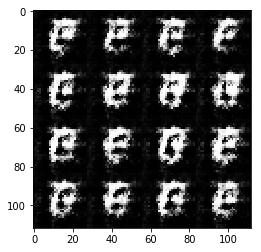

Epoch 0/2 Batch Step 310... Discriminator Loss: 1.1266... Generator Loss: 1.0113
Epoch 0/2 Batch Step 320... Discriminator Loss: 1.0967... Generator Loss: 1.0027
Epoch 0/2 Batch Step 330... Discriminator Loss: 1.0931... Generator Loss: 1.0201
Epoch 0/2 Batch Step 340... Discriminator Loss: 1.1113... Generator Loss: 1.0021
Epoch 0/2 Batch Step 350... Discriminator Loss: 1.0870... Generator Loss: 1.0512
Epoch 0/2 Batch Step 360... Discriminator Loss: 1.1092... Generator Loss: 1.0230
Epoch 0/2 Batch Step 370... Discriminator Loss: 1.1309... Generator Loss: 0.9902
Epoch 0/2 Batch Step 380... Discriminator Loss: 0.9749... Generator Loss: 1.1327
Epoch 0/2 Batch Step 390... Discriminator Loss: 1.1062... Generator Loss: 1.0399
Epoch 0/2 Batch Step 400... Discriminator Loss: 1.1086... Generator Loss: 1.0239


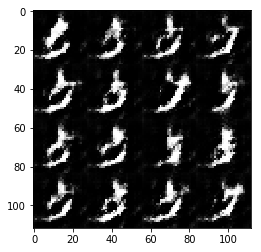

Epoch 0/2 Batch Step 410... Discriminator Loss: 1.1230... Generator Loss: 1.0139
Epoch 0/2 Batch Step 420... Discriminator Loss: 1.1138... Generator Loss: 1.0236
Epoch 0/2 Batch Step 430... Discriminator Loss: 1.1111... Generator Loss: 0.9962
Epoch 0/2 Batch Step 440... Discriminator Loss: 1.0994... Generator Loss: 1.0312
Epoch 0/2 Batch Step 450... Discriminator Loss: 1.0948... Generator Loss: 1.0126
Epoch 0/2 Batch Step 460... Discriminator Loss: 1.0498... Generator Loss: 1.0747
Epoch 0/2 Batch Step 470... Discriminator Loss: 1.0833... Generator Loss: 1.0554
Epoch 0/2 Batch Step 480... Discriminator Loss: 1.1064... Generator Loss: 1.0204
Epoch 0/2 Batch Step 490... Discriminator Loss: 1.2066... Generator Loss: 0.9857
Epoch 0/2 Batch Step 500... Discriminator Loss: 1.1965... Generator Loss: 1.0601


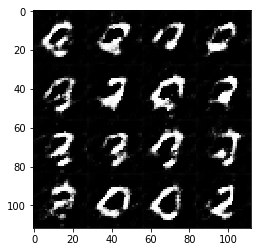

Epoch 0/2 Batch Step 510... Discriminator Loss: 1.1843... Generator Loss: 0.9765
Epoch 0/2 Batch Step 520... Discriminator Loss: 1.1697... Generator Loss: 0.9705
Epoch 0/2 Batch Step 530... Discriminator Loss: 1.1572... Generator Loss: 0.9567
Epoch 0/2 Batch Step 540... Discriminator Loss: 1.1295... Generator Loss: 1.0048
Epoch 0/2 Batch Step 550... Discriminator Loss: 1.1385... Generator Loss: 0.9847
Epoch 0/2 Batch Step 560... Discriminator Loss: 1.1585... Generator Loss: 0.9705
Epoch 0/2 Batch Step 570... Discriminator Loss: 1.2222... Generator Loss: 1.0486
Epoch 0/2 Batch Step 580... Discriminator Loss: 1.1555... Generator Loss: 0.9752
Epoch 0/2 Batch Step 590... Discriminator Loss: 1.1250... Generator Loss: 0.9892
Epoch 0/2 Batch Step 600... Discriminator Loss: 1.1519... Generator Loss: 0.9889


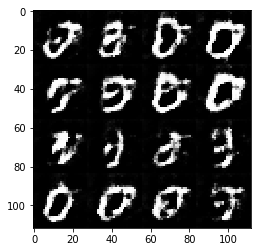

Epoch 0/2 Batch Step 610... Discriminator Loss: 1.2431... Generator Loss: 0.9945
Epoch 0/2 Batch Step 620... Discriminator Loss: 1.2018... Generator Loss: 0.9645
Epoch 0/2 Batch Step 630... Discriminator Loss: 1.0922... Generator Loss: 1.0136
Epoch 0/2 Batch Step 640... Discriminator Loss: 1.1349... Generator Loss: 0.9930
Epoch 0/2 Batch Step 650... Discriminator Loss: 1.1887... Generator Loss: 0.9334
Epoch 0/2 Batch Step 660... Discriminator Loss: 1.1685... Generator Loss: 0.9641
Epoch 0/2 Batch Step 670... Discriminator Loss: 1.1985... Generator Loss: 0.9696
Epoch 0/2 Batch Step 680... Discriminator Loss: 1.1796... Generator Loss: 0.9814
Epoch 0/2 Batch Step 690... Discriminator Loss: 1.1571... Generator Loss: 0.9550
Epoch 0/2 Batch Step 700... Discriminator Loss: 1.1488... Generator Loss: 0.9639


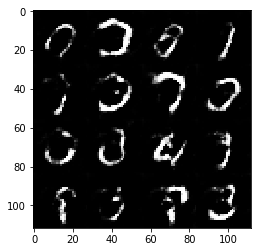

Epoch 0/2 Batch Step 710... Discriminator Loss: 1.1897... Generator Loss: 0.9154
Epoch 0/2 Batch Step 720... Discriminator Loss: 1.1125... Generator Loss: 0.9998
Epoch 0/2 Batch Step 730... Discriminator Loss: 1.2194... Generator Loss: 0.9243
Epoch 0/2 Batch Step 740... Discriminator Loss: 1.1627... Generator Loss: 0.9935
Epoch 0/2 Batch Step 750... Discriminator Loss: 1.1604... Generator Loss: 1.0000
Epoch 0/2 Batch Step 760... Discriminator Loss: 1.1442... Generator Loss: 0.9823
Epoch 0/2 Batch Step 770... Discriminator Loss: 1.1554... Generator Loss: 0.9764
Epoch 0/2 Batch Step 780... Discriminator Loss: 1.1611... Generator Loss: 0.9772
Epoch 0/2 Batch Step 790... Discriminator Loss: 1.1727... Generator Loss: 0.9560
Epoch 0/2 Batch Step 800... Discriminator Loss: 1.1724... Generator Loss: 0.9826


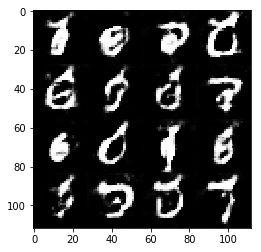

Epoch 0/2 Batch Step 810... Discriminator Loss: 1.1719... Generator Loss: 0.9481
Epoch 0/2 Batch Step 820... Discriminator Loss: 1.1515... Generator Loss: 0.9650
Epoch 0/2 Batch Step 830... Discriminator Loss: 1.1571... Generator Loss: 0.9640
Epoch 0/2 Batch Step 840... Discriminator Loss: 1.1911... Generator Loss: 0.9285
Epoch 0/2 Batch Step 850... Discriminator Loss: 1.1837... Generator Loss: 0.9520
Epoch 0/2 Batch Step 860... Discriminator Loss: 1.1420... Generator Loss: 0.9262
Epoch 0/2 Batch Step 870... Discriminator Loss: 1.3840... Generator Loss: 1.0109
Epoch 0/2 Batch Step 880... Discriminator Loss: 1.1843... Generator Loss: 0.9509
Epoch 0/2 Batch Step 890... Discriminator Loss: 1.1573... Generator Loss: 0.9834
Epoch 0/2 Batch Step 900... Discriminator Loss: 1.1824... Generator Loss: 0.9347


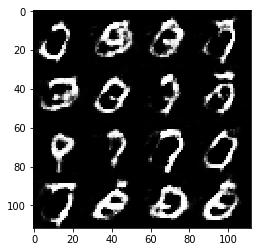

Epoch 0/2 Batch Step 910... Discriminator Loss: 1.1852... Generator Loss: 0.9510
Epoch 0/2 Batch Step 920... Discriminator Loss: 1.1853... Generator Loss: 0.9850
Epoch 0/2 Batch Step 930... Discriminator Loss: 1.1880... Generator Loss: 0.9375
Epoch 1/2 Batch Step 940... Discriminator Loss: 1.1803... Generator Loss: 0.9028
Epoch 1/2 Batch Step 950... Discriminator Loss: 1.1557... Generator Loss: 0.9762
Epoch 1/2 Batch Step 960... Discriminator Loss: 1.1259... Generator Loss: 0.9889
Epoch 1/2 Batch Step 970... Discriminator Loss: 1.2075... Generator Loss: 0.8921
Epoch 1/2 Batch Step 980... Discriminator Loss: 1.1914... Generator Loss: 0.9930
Epoch 1/2 Batch Step 990... Discriminator Loss: 1.2210... Generator Loss: 0.9601
Epoch 1/2 Batch Step 1000... Discriminator Loss: 1.1679... Generator Loss: 0.9508


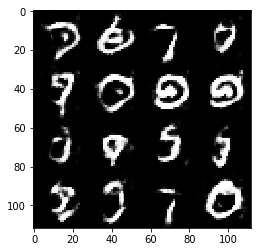

Epoch 1/2 Batch Step 1010... Discriminator Loss: 1.1878... Generator Loss: 0.9148
Epoch 1/2 Batch Step 1020... Discriminator Loss: 1.1899... Generator Loss: 0.9500
Epoch 1/2 Batch Step 1030... Discriminator Loss: 1.1537... Generator Loss: 0.9591
Epoch 1/2 Batch Step 1040... Discriminator Loss: 1.1877... Generator Loss: 0.9512
Epoch 1/2 Batch Step 1050... Discriminator Loss: 1.1729... Generator Loss: 0.9617
Epoch 1/2 Batch Step 1060... Discriminator Loss: 1.1919... Generator Loss: 0.9178
Epoch 1/2 Batch Step 1070... Discriminator Loss: 1.1516... Generator Loss: 0.9630
Epoch 1/2 Batch Step 1080... Discriminator Loss: 1.1525... Generator Loss: 0.9999
Epoch 1/2 Batch Step 1090... Discriminator Loss: 1.1714... Generator Loss: 0.9806
Epoch 1/2 Batch Step 1100... Discriminator Loss: 1.1619... Generator Loss: 0.9494


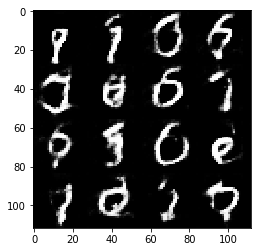

Epoch 1/2 Batch Step 1110... Discriminator Loss: 1.1500... Generator Loss: 0.9783
Epoch 1/2 Batch Step 1120... Discriminator Loss: 1.2179... Generator Loss: 0.9168
Epoch 1/2 Batch Step 1130... Discriminator Loss: 1.1569... Generator Loss: 0.9615
Epoch 1/2 Batch Step 1140... Discriminator Loss: 1.1759... Generator Loss: 0.9521
Epoch 1/2 Batch Step 1150... Discriminator Loss: 1.1833... Generator Loss: 0.9707
Epoch 1/2 Batch Step 1160... Discriminator Loss: 1.2451... Generator Loss: 0.9602
Epoch 1/2 Batch Step 1170... Discriminator Loss: 1.2261... Generator Loss: 0.9287
Epoch 1/2 Batch Step 1180... Discriminator Loss: 1.2523... Generator Loss: 0.9120
Epoch 1/2 Batch Step 1190... Discriminator Loss: 1.1711... Generator Loss: 0.9604
Epoch 1/2 Batch Step 1200... Discriminator Loss: 1.1803... Generator Loss: 0.9482


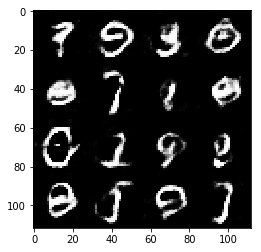

Epoch 1/2 Batch Step 1210... Discriminator Loss: 1.2408... Generator Loss: 0.9071
Epoch 1/2 Batch Step 1220... Discriminator Loss: 1.2230... Generator Loss: 0.8934
Epoch 1/2 Batch Step 1230... Discriminator Loss: 1.2741... Generator Loss: 0.8615
Epoch 1/2 Batch Step 1240... Discriminator Loss: 1.1741... Generator Loss: 0.9743
Epoch 1/2 Batch Step 1250... Discriminator Loss: 1.2360... Generator Loss: 0.8645
Epoch 1/2 Batch Step 1260... Discriminator Loss: 1.2519... Generator Loss: 0.9125
Epoch 1/2 Batch Step 1270... Discriminator Loss: 1.2100... Generator Loss: 0.9299
Epoch 1/2 Batch Step 1280... Discriminator Loss: 1.2154... Generator Loss: 0.9457
Epoch 1/2 Batch Step 1290... Discriminator Loss: 1.2215... Generator Loss: 0.8930
Epoch 1/2 Batch Step 1300... Discriminator Loss: 1.2163... Generator Loss: 0.8993


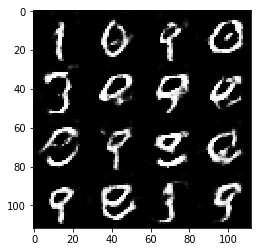

Epoch 1/2 Batch Step 1310... Discriminator Loss: 1.1923... Generator Loss: 0.9367
Epoch 1/2 Batch Step 1320... Discriminator Loss: 1.2807... Generator Loss: 0.8798
Epoch 1/2 Batch Step 1330... Discriminator Loss: 1.2094... Generator Loss: 0.9363
Epoch 1/2 Batch Step 1340... Discriminator Loss: 1.2315... Generator Loss: 0.8957
Epoch 1/2 Batch Step 1350... Discriminator Loss: 1.2139... Generator Loss: 0.8903
Epoch 1/2 Batch Step 1360... Discriminator Loss: 1.2121... Generator Loss: 0.9373
Epoch 1/2 Batch Step 1370... Discriminator Loss: 1.1635... Generator Loss: 0.9434
Epoch 1/2 Batch Step 1380... Discriminator Loss: 1.2675... Generator Loss: 0.9890
Epoch 1/2 Batch Step 1390... Discriminator Loss: 1.1573... Generator Loss: 0.9863
Epoch 1/2 Batch Step 1400... Discriminator Loss: 1.2905... Generator Loss: 0.8554


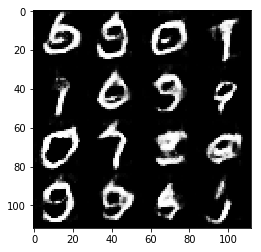

Epoch 1/2 Batch Step 1410... Discriminator Loss: 1.2227... Generator Loss: 0.9601
Epoch 1/2 Batch Step 1420... Discriminator Loss: 1.2368... Generator Loss: 0.8752
Epoch 1/2 Batch Step 1430... Discriminator Loss: 1.2230... Generator Loss: 0.9117
Epoch 1/2 Batch Step 1440... Discriminator Loss: 1.2119... Generator Loss: 0.8998
Epoch 1/2 Batch Step 1450... Discriminator Loss: 1.2300... Generator Loss: 0.9036
Epoch 1/2 Batch Step 1460... Discriminator Loss: 1.2158... Generator Loss: 0.8899
Epoch 1/2 Batch Step 1470... Discriminator Loss: 1.1480... Generator Loss: 0.9957
Epoch 1/2 Batch Step 1480... Discriminator Loss: 1.2011... Generator Loss: 0.9180
Epoch 1/2 Batch Step 1490... Discriminator Loss: 1.1767... Generator Loss: 0.9542
Epoch 1/2 Batch Step 1500... Discriminator Loss: 1.2384... Generator Loss: 0.9245


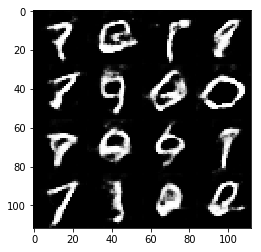

Epoch 1/2 Batch Step 1510... Discriminator Loss: 1.2158... Generator Loss: 0.9133
Epoch 1/2 Batch Step 1520... Discriminator Loss: 1.1894... Generator Loss: 0.9455
Epoch 1/2 Batch Step 1530... Discriminator Loss: 1.1444... Generator Loss: 0.9767
Epoch 1/2 Batch Step 1540... Discriminator Loss: 1.2143... Generator Loss: 0.9273
Epoch 1/2 Batch Step 1550... Discriminator Loss: 1.1993... Generator Loss: 0.9272
Epoch 1/2 Batch Step 1560... Discriminator Loss: 1.2507... Generator Loss: 0.8672
Epoch 1/2 Batch Step 1570... Discriminator Loss: 1.2119... Generator Loss: 0.9203
Epoch 1/2 Batch Step 1580... Discriminator Loss: 1.2902... Generator Loss: 0.9559
Epoch 1/2 Batch Step 1590... Discriminator Loss: 1.2731... Generator Loss: 0.8606
Epoch 1/2 Batch Step 1600... Discriminator Loss: 1.3193... Generator Loss: 0.9084


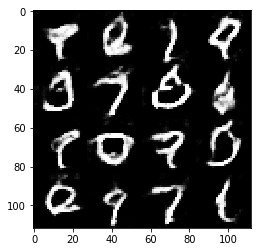

Epoch 1/2 Batch Step 1610... Discriminator Loss: 1.2655... Generator Loss: 0.8936
Epoch 1/2 Batch Step 1620... Discriminator Loss: 1.2110... Generator Loss: 0.9489
Epoch 1/2 Batch Step 1630... Discriminator Loss: 1.2536... Generator Loss: 0.9008
Epoch 1/2 Batch Step 1640... Discriminator Loss: 1.2049... Generator Loss: 0.9167
Epoch 1/2 Batch Step 1650... Discriminator Loss: 1.2017... Generator Loss: 0.9299
Epoch 1/2 Batch Step 1660... Discriminator Loss: 1.2296... Generator Loss: 0.9014
Epoch 1/2 Batch Step 1670... Discriminator Loss: 1.1725... Generator Loss: 0.9282
Epoch 1/2 Batch Step 1680... Discriminator Loss: 1.1739... Generator Loss: 0.9527
Epoch 1/2 Batch Step 1690... Discriminator Loss: 1.2412... Generator Loss: 0.9834
Epoch 1/2 Batch Step 1700... Discriminator Loss: 1.2345... Generator Loss: 0.8849


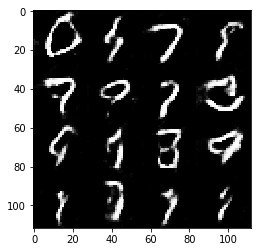

Epoch 1/2 Batch Step 1710... Discriminator Loss: 1.2343... Generator Loss: 0.8797
Epoch 1/2 Batch Step 1720... Discriminator Loss: 1.2621... Generator Loss: 0.9229
Epoch 1/2 Batch Step 1730... Discriminator Loss: 1.2329... Generator Loss: 0.9138
Epoch 1/2 Batch Step 1740... Discriminator Loss: 1.2340... Generator Loss: 0.8878
Epoch 1/2 Batch Step 1750... Discriminator Loss: 1.2098... Generator Loss: 0.9002
Epoch 1/2 Batch Step 1760... Discriminator Loss: 1.2217... Generator Loss: 0.9136
Epoch 1/2 Batch Step 1770... Discriminator Loss: 1.2115... Generator Loss: 0.9239
Epoch 1/2 Batch Step 1780... Discriminator Loss: 1.2508... Generator Loss: 0.9282
Epoch 1/2 Batch Step 1790... Discriminator Loss: 1.1641... Generator Loss: 0.9408
Epoch 1/2 Batch Step 1800... Discriminator Loss: 1.3099... Generator Loss: 1.0071


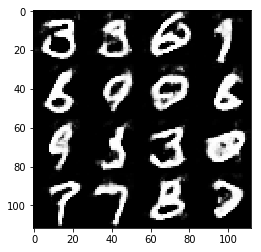

Epoch 1/2 Batch Step 1810... Discriminator Loss: 1.2821... Generator Loss: 0.8738
Epoch 1/2 Batch Step 1820... Discriminator Loss: 1.2177... Generator Loss: 0.9155
Epoch 1/2 Batch Step 1830... Discriminator Loss: 1.2051... Generator Loss: 0.9205
Epoch 1/2 Batch Step 1840... Discriminator Loss: 1.2248... Generator Loss: 0.9074
Epoch 1/2 Batch Step 1850... Discriminator Loss: 1.2960... Generator Loss: 0.9163
Epoch 1/2 Batch Step 1860... Discriminator Loss: 1.1963... Generator Loss: 0.9265
Epoch 1/2 Batch Step 1870... Discriminator Loss: 1.2120... Generator Loss: 0.9489
Done Training!


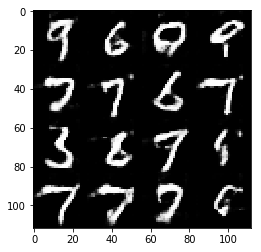

In [65]:
batch_size = 64
z_dim = 100
learning_rate = 0.0001
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 0/1 Batch Step 10... Discriminator Loss: 2.7301... Generator Loss: 0.4717
Epoch 0/1 Batch Step 20... Discriminator Loss: 1.4021... Generator Loss: 1.9946
Epoch 0/1 Batch Step 30... Discriminator Loss: 1.3043... Generator Loss: 1.1070
Epoch 0/1 Batch Step 40... Discriminator Loss: 0.7545... Generator Loss: 2.4922
Epoch 0/1 Batch Step 50... Discriminator Loss: 0.6957... Generator Loss: 2.1845
Epoch 0/1 Batch Step 60... Discriminator Loss: 0.5976... Generator Loss: 1.9688
Epoch 0/1 Batch Step 70... Discriminator Loss: 0.4598... Generator Loss: 3.4518
Epoch 0/1 Batch Step 80... Discriminator Loss: 0.5681... Generator Loss: 2.2546
Epoch 0/1 Batch Step 90... Discriminator Loss: 0.5169... Generator Loss: 2.4113
Epoch 0/1 Batch Step 100... Discriminator Loss: 0.8487... Generator Loss: 3.0519


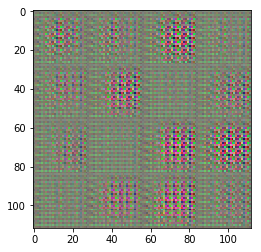

Epoch 0/1 Batch Step 110... Discriminator Loss: 0.4251... Generator Loss: 3.1414
Epoch 0/1 Batch Step 120... Discriminator Loss: 0.4867... Generator Loss: 2.3696
Epoch 0/1 Batch Step 130... Discriminator Loss: 0.4891... Generator Loss: 2.7390
Epoch 0/1 Batch Step 140... Discriminator Loss: 0.4630... Generator Loss: 2.5581
Epoch 0/1 Batch Step 150... Discriminator Loss: 0.4970... Generator Loss: 2.5778
Epoch 0/1 Batch Step 160... Discriminator Loss: 0.3940... Generator Loss: 3.2459
Epoch 0/1 Batch Step 170... Discriminator Loss: 0.4804... Generator Loss: 2.3615
Epoch 0/1 Batch Step 180... Discriminator Loss: 0.7203... Generator Loss: 2.2487
Epoch 0/1 Batch Step 190... Discriminator Loss: 0.4855... Generator Loss: 2.6854
Epoch 0/1 Batch Step 200... Discriminator Loss: 0.4541... Generator Loss: 2.4464


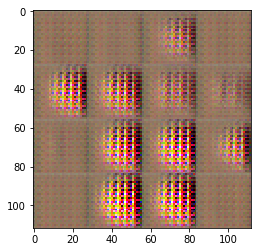

Epoch 0/1 Batch Step 210... Discriminator Loss: 0.4431... Generator Loss: 2.9007
Epoch 0/1 Batch Step 220... Discriminator Loss: 0.5924... Generator Loss: 2.0649
Epoch 0/1 Batch Step 230... Discriminator Loss: 0.5344... Generator Loss: 2.1894
Epoch 0/1 Batch Step 240... Discriminator Loss: 0.4529... Generator Loss: 2.5707
Epoch 0/1 Batch Step 250... Discriminator Loss: 0.4676... Generator Loss: 2.5073
Epoch 0/1 Batch Step 260... Discriminator Loss: 1.0757... Generator Loss: 2.1752
Epoch 0/1 Batch Step 270... Discriminator Loss: 0.5675... Generator Loss: 2.5442
Epoch 0/1 Batch Step 280... Discriminator Loss: 0.4493... Generator Loss: 2.6285
Epoch 0/1 Batch Step 290... Discriminator Loss: 0.5213... Generator Loss: 2.6174
Epoch 0/1 Batch Step 300... Discriminator Loss: 0.4345... Generator Loss: 2.8930


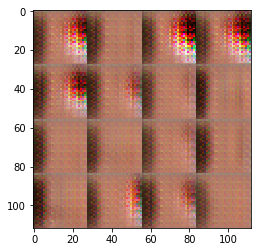

Epoch 0/1 Batch Step 310... Discriminator Loss: 0.5757... Generator Loss: 1.9752
Epoch 0/1 Batch Step 320... Discriminator Loss: 0.5327... Generator Loss: 2.1304
Epoch 0/1 Batch Step 330... Discriminator Loss: 0.4999... Generator Loss: 2.3478
Epoch 0/1 Batch Step 340... Discriminator Loss: 0.6100... Generator Loss: 2.2752
Epoch 0/1 Batch Step 350... Discriminator Loss: 0.6255... Generator Loss: 1.8134
Epoch 0/1 Batch Step 360... Discriminator Loss: 0.5301... Generator Loss: 2.5479
Epoch 0/1 Batch Step 370... Discriminator Loss: 0.5863... Generator Loss: 2.2426
Epoch 0/1 Batch Step 380... Discriminator Loss: 0.4848... Generator Loss: 2.3308
Epoch 0/1 Batch Step 390... Discriminator Loss: 0.7830... Generator Loss: 1.2371
Epoch 0/1 Batch Step 400... Discriminator Loss: 1.1124... Generator Loss: 2.4413


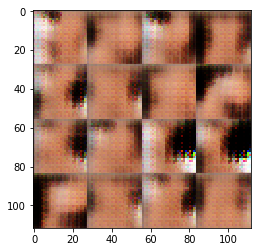

Epoch 0/1 Batch Step 410... Discriminator Loss: 0.7414... Generator Loss: 2.6393
Epoch 0/1 Batch Step 420... Discriminator Loss: 1.1046... Generator Loss: 3.0785
Epoch 0/1 Batch Step 430... Discriminator Loss: 0.8578... Generator Loss: 1.4934
Epoch 0/1 Batch Step 440... Discriminator Loss: 0.6803... Generator Loss: 1.8812
Epoch 0/1 Batch Step 450... Discriminator Loss: 0.6803... Generator Loss: 2.5673
Epoch 0/1 Batch Step 460... Discriminator Loss: 1.0742... Generator Loss: 0.8859
Epoch 0/1 Batch Step 470... Discriminator Loss: 0.6423... Generator Loss: 2.3867
Epoch 0/1 Batch Step 480... Discriminator Loss: 0.6819... Generator Loss: 1.7889
Epoch 0/1 Batch Step 490... Discriminator Loss: 0.8448... Generator Loss: 1.2003
Epoch 0/1 Batch Step 500... Discriminator Loss: 0.6679... Generator Loss: 1.6700


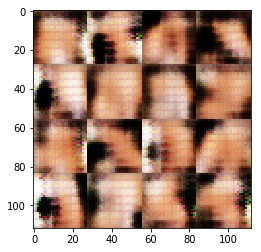

Epoch 0/1 Batch Step 510... Discriminator Loss: 0.6703... Generator Loss: 1.8427
Epoch 0/1 Batch Step 520... Discriminator Loss: 0.7190... Generator Loss: 1.6211
Epoch 0/1 Batch Step 530... Discriminator Loss: 0.7487... Generator Loss: 1.3866
Epoch 0/1 Batch Step 540... Discriminator Loss: 0.6093... Generator Loss: 2.2040
Epoch 0/1 Batch Step 550... Discriminator Loss: 1.0249... Generator Loss: 1.5200
Epoch 0/1 Batch Step 560... Discriminator Loss: 0.6944... Generator Loss: 1.7554
Epoch 0/1 Batch Step 570... Discriminator Loss: 0.6024... Generator Loss: 1.9118
Epoch 0/1 Batch Step 580... Discriminator Loss: 0.8395... Generator Loss: 1.3073
Epoch 0/1 Batch Step 590... Discriminator Loss: 0.8355... Generator Loss: 1.8223
Epoch 0/1 Batch Step 600... Discriminator Loss: 0.7093... Generator Loss: 2.3482


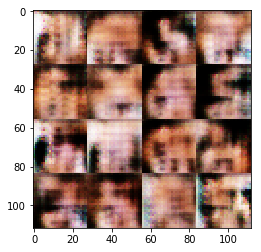

Epoch 0/1 Batch Step 610... Discriminator Loss: 0.6246... Generator Loss: 1.7412
Epoch 0/1 Batch Step 620... Discriminator Loss: 0.7006... Generator Loss: 1.4534
Epoch 0/1 Batch Step 630... Discriminator Loss: 1.2023... Generator Loss: 1.0930
Epoch 0/1 Batch Step 640... Discriminator Loss: 0.8713... Generator Loss: 1.0923
Epoch 0/1 Batch Step 650... Discriminator Loss: 0.8123... Generator Loss: 1.3633
Epoch 0/1 Batch Step 660... Discriminator Loss: 0.6209... Generator Loss: 1.9409
Epoch 0/1 Batch Step 670... Discriminator Loss: 1.6061... Generator Loss: 2.4699
Epoch 0/1 Batch Step 680... Discriminator Loss: 0.8423... Generator Loss: 1.3127
Epoch 0/1 Batch Step 690... Discriminator Loss: 0.7643... Generator Loss: 1.3271
Epoch 0/1 Batch Step 700... Discriminator Loss: 0.9861... Generator Loss: 2.1167


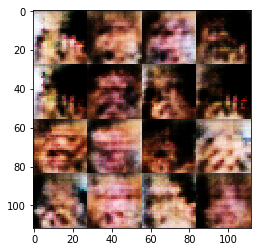

Epoch 0/1 Batch Step 710... Discriminator Loss: 1.0194... Generator Loss: 1.8048
Epoch 0/1 Batch Step 720... Discriminator Loss: 0.8655... Generator Loss: 1.2006
Epoch 0/1 Batch Step 730... Discriminator Loss: 0.8162... Generator Loss: 1.8366
Epoch 0/1 Batch Step 740... Discriminator Loss: 1.0596... Generator Loss: 1.2921
Epoch 0/1 Batch Step 750... Discriminator Loss: 0.8671... Generator Loss: 1.2301
Epoch 0/1 Batch Step 760... Discriminator Loss: 0.6515... Generator Loss: 1.9782
Epoch 0/1 Batch Step 770... Discriminator Loss: 1.3572... Generator Loss: 2.6387
Epoch 0/1 Batch Step 780... Discriminator Loss: 1.4436... Generator Loss: 2.1544
Epoch 0/1 Batch Step 790... Discriminator Loss: 0.8685... Generator Loss: 1.1056
Epoch 0/1 Batch Step 800... Discriminator Loss: 1.0714... Generator Loss: 2.1414


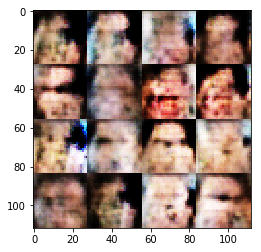

Epoch 0/1 Batch Step 810... Discriminator Loss: 0.8399... Generator Loss: 1.3105
Epoch 0/1 Batch Step 820... Discriminator Loss: 0.8081... Generator Loss: 1.5993
Epoch 0/1 Batch Step 830... Discriminator Loss: 1.2218... Generator Loss: 1.5608
Epoch 0/1 Batch Step 840... Discriminator Loss: 0.8176... Generator Loss: 1.5208
Epoch 0/1 Batch Step 850... Discriminator Loss: 0.7288... Generator Loss: 1.7508
Epoch 0/1 Batch Step 860... Discriminator Loss: 1.4647... Generator Loss: 0.5345
Epoch 0/1 Batch Step 870... Discriminator Loss: 1.0377... Generator Loss: 1.1650
Epoch 0/1 Batch Step 880... Discriminator Loss: 0.9182... Generator Loss: 1.4318
Epoch 0/1 Batch Step 890... Discriminator Loss: 0.8421... Generator Loss: 1.6232
Epoch 0/1 Batch Step 900... Discriminator Loss: 0.9871... Generator Loss: 2.0024


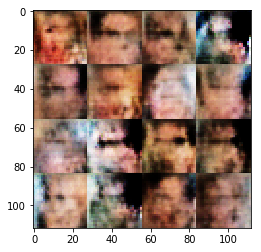

Epoch 0/1 Batch Step 910... Discriminator Loss: 1.0415... Generator Loss: 0.9033
Epoch 0/1 Batch Step 920... Discriminator Loss: 0.8302... Generator Loss: 1.4263
Epoch 0/1 Batch Step 930... Discriminator Loss: 0.9048... Generator Loss: 1.1805
Epoch 0/1 Batch Step 940... Discriminator Loss: 0.9455... Generator Loss: 1.0614
Epoch 0/1 Batch Step 950... Discriminator Loss: 1.1097... Generator Loss: 1.1378
Epoch 0/1 Batch Step 960... Discriminator Loss: 0.9137... Generator Loss: 1.1382
Epoch 0/1 Batch Step 970... Discriminator Loss: 1.2460... Generator Loss: 0.7390
Epoch 0/1 Batch Step 980... Discriminator Loss: 0.8546... Generator Loss: 1.6641
Epoch 0/1 Batch Step 990... Discriminator Loss: 0.7881... Generator Loss: 1.4177
Epoch 0/1 Batch Step 1000... Discriminator Loss: 1.0997... Generator Loss: 2.0620


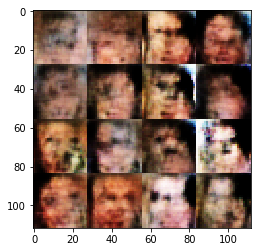

Epoch 0/1 Batch Step 1010... Discriminator Loss: 0.9579... Generator Loss: 1.0560
Epoch 0/1 Batch Step 1020... Discriminator Loss: 1.1001... Generator Loss: 0.7832
Epoch 0/1 Batch Step 1030... Discriminator Loss: 1.0351... Generator Loss: 1.1914
Epoch 0/1 Batch Step 1040... Discriminator Loss: 1.0134... Generator Loss: 1.7181
Epoch 0/1 Batch Step 1050... Discriminator Loss: 0.8432... Generator Loss: 1.2472
Epoch 0/1 Batch Step 1060... Discriminator Loss: 1.3306... Generator Loss: 0.5585
Epoch 0/1 Batch Step 1070... Discriminator Loss: 1.0255... Generator Loss: 1.5471
Epoch 0/1 Batch Step 1080... Discriminator Loss: 0.8598... Generator Loss: 1.3652
Epoch 0/1 Batch Step 1090... Discriminator Loss: 1.3950... Generator Loss: 0.6112
Epoch 0/1 Batch Step 1100... Discriminator Loss: 1.0647... Generator Loss: 0.9764


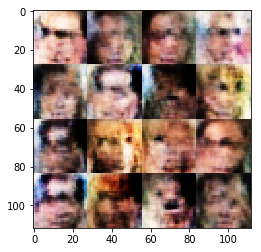

Epoch 0/1 Batch Step 1110... Discriminator Loss: 0.9028... Generator Loss: 1.2644
Epoch 0/1 Batch Step 1120... Discriminator Loss: 0.9153... Generator Loss: 1.2149
Epoch 0/1 Batch Step 1130... Discriminator Loss: 1.0703... Generator Loss: 1.7366
Epoch 0/1 Batch Step 1140... Discriminator Loss: 1.0029... Generator Loss: 0.9899
Epoch 0/1 Batch Step 1150... Discriminator Loss: 1.3039... Generator Loss: 0.6204
Epoch 0/1 Batch Step 1160... Discriminator Loss: 0.9257... Generator Loss: 1.2842
Epoch 0/1 Batch Step 1170... Discriminator Loss: 1.0295... Generator Loss: 1.0615
Epoch 0/1 Batch Step 1180... Discriminator Loss: 1.2431... Generator Loss: 1.7691
Epoch 0/1 Batch Step 1190... Discriminator Loss: 1.1546... Generator Loss: 0.8125
Epoch 0/1 Batch Step 1200... Discriminator Loss: 0.9043... Generator Loss: 1.2194


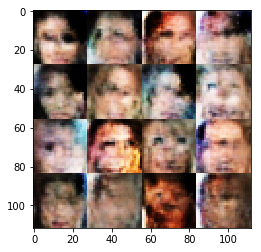

Epoch 0/1 Batch Step 1210... Discriminator Loss: 1.0389... Generator Loss: 1.7269
Epoch 0/1 Batch Step 1220... Discriminator Loss: 1.1862... Generator Loss: 0.6978
Epoch 0/1 Batch Step 1230... Discriminator Loss: 0.9502... Generator Loss: 1.1723
Epoch 0/1 Batch Step 1240... Discriminator Loss: 0.8825... Generator Loss: 1.0454
Epoch 0/1 Batch Step 1250... Discriminator Loss: 0.9431... Generator Loss: 1.5927
Epoch 0/1 Batch Step 1260... Discriminator Loss: 0.8440... Generator Loss: 1.3330
Epoch 0/1 Batch Step 1270... Discriminator Loss: 0.9424... Generator Loss: 1.5573
Epoch 0/1 Batch Step 1280... Discriminator Loss: 1.4573... Generator Loss: 0.6735
Epoch 0/1 Batch Step 1290... Discriminator Loss: 1.3091... Generator Loss: 0.8283
Epoch 0/1 Batch Step 1300... Discriminator Loss: 1.0774... Generator Loss: 0.8962


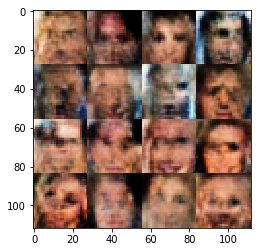

Epoch 0/1 Batch Step 1310... Discriminator Loss: 0.9404... Generator Loss: 1.5930
Epoch 0/1 Batch Step 1320... Discriminator Loss: 1.2614... Generator Loss: 1.1907
Epoch 0/1 Batch Step 1330... Discriminator Loss: 1.0157... Generator Loss: 1.1009
Epoch 0/1 Batch Step 1340... Discriminator Loss: 1.0965... Generator Loss: 1.8879
Epoch 0/1 Batch Step 1350... Discriminator Loss: 0.9999... Generator Loss: 0.9894
Epoch 0/1 Batch Step 1360... Discriminator Loss: 0.8784... Generator Loss: 1.4667
Epoch 0/1 Batch Step 1370... Discriminator Loss: 0.9840... Generator Loss: 1.1221
Epoch 0/1 Batch Step 1380... Discriminator Loss: 1.0144... Generator Loss: 0.9692
Epoch 0/1 Batch Step 1390... Discriminator Loss: 1.0816... Generator Loss: 1.3950
Epoch 0/1 Batch Step 1400... Discriminator Loss: 0.8711... Generator Loss: 1.5952


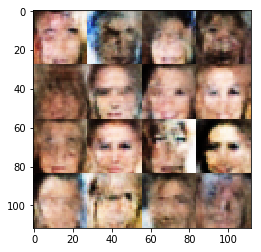

Epoch 0/1 Batch Step 1410... Discriminator Loss: 1.0750... Generator Loss: 1.2210
Epoch 0/1 Batch Step 1420... Discriminator Loss: 1.0910... Generator Loss: 1.1329
Epoch 0/1 Batch Step 1430... Discriminator Loss: 1.0268... Generator Loss: 1.5370
Epoch 0/1 Batch Step 1440... Discriminator Loss: 1.0264... Generator Loss: 0.9640
Epoch 0/1 Batch Step 1450... Discriminator Loss: 0.9487... Generator Loss: 1.3697
Epoch 0/1 Batch Step 1460... Discriminator Loss: 0.8131... Generator Loss: 1.5495
Epoch 0/1 Batch Step 1470... Discriminator Loss: 1.3734... Generator Loss: 1.1292
Epoch 0/1 Batch Step 1480... Discriminator Loss: 1.0076... Generator Loss: 1.0737
Epoch 0/1 Batch Step 1490... Discriminator Loss: 1.0048... Generator Loss: 0.9953
Epoch 0/1 Batch Step 1500... Discriminator Loss: 0.9037... Generator Loss: 1.3089


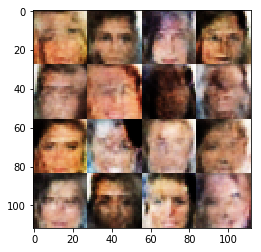

Epoch 0/1 Batch Step 1510... Discriminator Loss: 0.8588... Generator Loss: 1.2703
Epoch 0/1 Batch Step 1520... Discriminator Loss: 1.2658... Generator Loss: 1.7959
Epoch 0/1 Batch Step 1530... Discriminator Loss: 1.0587... Generator Loss: 1.1862
Epoch 0/1 Batch Step 1540... Discriminator Loss: 0.9220... Generator Loss: 1.4898
Epoch 0/1 Batch Step 1550... Discriminator Loss: 0.9731... Generator Loss: 1.3275
Epoch 0/1 Batch Step 1560... Discriminator Loss: 0.9566... Generator Loss: 1.2408
Epoch 0/1 Batch Step 1570... Discriminator Loss: 1.8426... Generator Loss: 2.3526
Epoch 0/1 Batch Step 1580... Discriminator Loss: 1.1759... Generator Loss: 1.2319
Epoch 0/1 Batch Step 1590... Discriminator Loss: 1.1327... Generator Loss: 1.0564
Epoch 0/1 Batch Step 1600... Discriminator Loss: 1.0194... Generator Loss: 1.0498


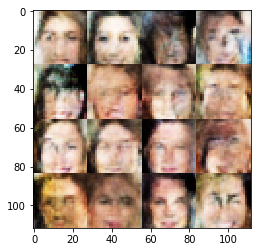

Done Training!


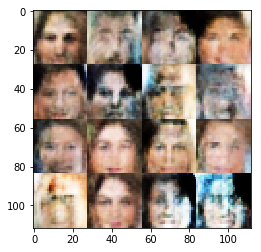

In [122]:
batch_size = 64
z_dim = 100
learning_rate = 0.0003
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.